In [1]:
from random import randint
from collections import defaultdict
from uuid import uuid4
from dataclasses import dataclass
import json

import matplotlib.pyplot as plt
from ipynb.fs.full.Observer import CaptureMachine, TrackedObject, CaptureConfiguration, Camera, hStackImages, vStackImages
import dma.MechaCombat as mc
QuantumSystem = mc.QuantumSystem

In [16]:
@dataclass
class QuantumObject(TrackedObject):
    name: str
    objectType: str

    def __eq__(self, other):
        return super().__eq__(other)
    
    def __post_init__(self):
        super().__post_init__()
        self.qid = str(uuid4())

    def previousVersion(self):
        return type(self)({camNum: change.lastChange if change is not None else None for camNum, change in self.changeSet.items()}, self.name, self.objectType)

    def __repr__(self):
        changeSet = {camNum: cS for camNum, cS in self.changeSet.items() if cS is not None and cS.changeType not in [None, 'delete']}
        return f"QO - {self.objectType} - {self.name} ({changeSet})"

In [3]:
class HarmonyMachine(CaptureMachine):
    states = ["idle", "unstable", "classify", "illegal"]
    modes = ["passive", "calibrate", "add", "move", "action"]
    MM_FOR_MOVE = 15

    def __init__(self, captureConfiguration: CaptureConfiguration):
        super().__init__(captureConfiguration)
        self.hc = self.cc
        mc.qs.reset()
        self.newObjectBuffer = []
    
    def isLegal(self, classifiedChange):
        return True
        
    def storeNewObject(self, objDef):
        self.lastMemory = objDef
        if not objDef.isNewObject:
            existingIndex = self.newObjectBuffer.index(objDef.previousVersion())
            existingObj = self.newObjectBuffer[existingIndex]
            existingObj.update(objDef, overwrite=self.cc.rsc.trackedObjectLastDistance(objDef) > self.MM_FOR_MOVE)
        else:
            self.newObjectBuffer.append(objDef)
        
        for camNum, change in objDef.changeSet.items():
            self.cc.cameras[camNum].commitChange(change)
        
        self.transitions.append({
            "obj": objDef,
            "cycle": self.cycleCounter,
            "cameraChanges":  {camNum: {"ref": cam.referenceFrame, "fin": cam.mostRecentFrame}
                               for camNum, cam in self.cc.cameras.items()}})
    
    def commitChanges(self, objDef):
        try:
            existingIndex = self.memory.index(objDef.previousVersion())
            existingObj = self.memory[existingIndex]
            print(f"Updating Memory {existingIndex}")
            existingObj.update(objDef, overwrite=self.cc.rsc.trackedObjectLastDistance(objDef) > self.MM_FOR_MOVE)
        except Exception:
            raise Exception("Cannot commit to unrecognized memory")
        self.lastMemory = existingObj
        
        for camNum, change in objDef.changeSet.items():
            self.cc.cameras[camNum].commitChange(change)

        self.transitions.append({
            "obj": objDef,
            "cycle": self.cycleCounter,
            "cameraChanges":  {camNum: {"ref": cam.referenceFrame, "fin": cam.mostRecentFrame}
                               for camNum, cam in self.cc.cameras.items()}})

    def annotateObject(self, oid, objName, objType):
        caps = {cap.oid: cap for cap in cm.newObjectBuffer}
        cap = caps[oid]
        center = cc.rsc.changeSetToRealCenter(cap)
        qObj = QuantumObject(cap.changeSet, objName, objType)
        factory = mc.ObjectFactories[objType]
        factory(objName)
        mc.XYLocation.set_location(objName, json.dumps(list(center) + [0]))
        cm.memory.append(qObj)
        cm.newObjectBuffer.remove(cap)
    
    def cycle(self):
        try:
            print(f"Starting Cycle {self.cycleCounter:5} -- {self}")
            self.cycleCounter += 1
            nextState = "idle"
            self.hc.capture()
            if self.mode == "passive":
                self.hc.setReference()
                return
            # else: mode in ["calibrate", "add", "move", "attack"]

            changes = self.referenceFrameDeltas()
            classification = None

            if changes.empty and self.state == "idle":
                self.hc.setReference()
            elif not changes.empty:
                nextState = "unstable"
                if self.state in ["unstable", "classify"] and changes == self.lastChanges:  # TODO: and cameraChangeOverlap
                    classification = self.classifyChanges(changes)
                    nextState = "classify"
                    if self.state == "classify" and self.lastClassification == classification:
                        if self.mode in ["move", "action"]:
                            assert not classification.isNewObject, f"Cannot add objects in {self.mode}"
                            assert self.isLegal(classification), f"{classificaton} is an illegal move"
                            nextState = "idle"
                            self.commitChanges(classification)
                            self.hc.setReference()
                        elif self.mode == "add":
                            nextState = "idle"
                            self.storeNewObject(classification)
                            self.hc.setReference()
                        elif self.mode == "calibrate":
                            try:
                                self.calibrateToObject(classification)
                            except AssertionError as ae:
                                print(f"Failed Calibration: {ae}")
                            nextState = "idle"
                            self.hc.setReference()
                        else:
                            raise Exception("Unrecognized State")
            self.state = nextState
            self.lastChanges = changes
            self.lastClassification = classification
        except:
            from traceback import format_exc
            print("CYCLE FAILURE!!!")
            print(format_exc())
            self.state = "unstable"
            self.lastChanges = None
            self.lastClassification = None
    
    def actionMode(self):
        self.mode = "action"
    
    def moveMode(self):
        self.mode = "move"
    
    def addMode(self):
        self.mode = "add"
    
    def passiveMode(self):
        self.mode = "passive"
    
    def startCalibration(self):
        self.calibrationPts = []
        self.mode = "calibrate"
    
    def abortCalibration(self):
        self.calibrationPts = []
        self.mode = "passive"
            
    def cycleForAddition(self):
        self.mode = "add"
        startLen = len(self.newObjectBuffer)
        while len(self.newObjectBuffer) == startLen:
            self.cycle()
        self.mode = "idle"
        return self.newObjectBuffer[-1]
            
    def cycleForChange(self):
        self.mode = "move"
        startLen = len(self.transitions)
        while len(self.transitions) == startLen:
            self.cycle()
        self.mode = "idle"
        return self.lastMemory
            
    def __repr__(self):
        return f"CapMac -- {self.mode} {str(len(self.calibrationPts)) + ' ' if self.mode == 'calibrate' else ''}{self.state}"

In [11]:
cc = CaptureConfiguration()
cc.loadConfiguration()
cameras = cc.cameras
cm = HarmonyMachine(cc)

Waiting for object...
Starting Cycle     0 -- CapMac -- add idle
No changes, setting reference
Starting Cycle     1 -- CapMac -- add idle
No changes, setting reference
Starting Cycle     2 -- CapMac -- add idle
Starting Cycle     3 -- CapMac -- add unstable
Starting Cycle     4 -- CapMac -- add unstable
Starting Cycle     5 -- CapMac -- add classify
Cam 0 - Adding (add) [1140.0, 336.0] by 71.0,54.0
Cam 2 - Nothing to commit
Cam 4 - Adding (add) [988.0, 432.0] by 70.0,65.0
Cam 6 - Adding (add) [660.0, 895.0] by 63.0,66.0
Stored new object. Setting reference


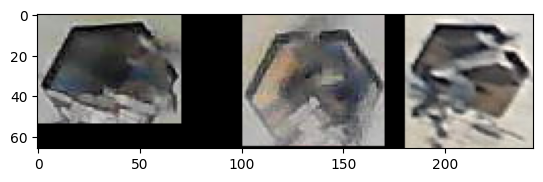

In [12]:
if __name__ == "__main__":
    for i in range(3):
        cm.cc.capture()
    print("Waiting for object...")
    obj = cm.cycleForAddition()
    # cm.annotateObject(obj.oid, "Foo", "Huntsman")
    plt.imshow(obj.visual())

Waiting for movement
Starting Cycle     5 -- CapMac -- move idle
No changes, setting reference
Starting Cycle     6 -- CapMac -- move idle
No changes, setting reference
Starting Cycle     7 -- CapMac -- move idle
Starting Cycle     8 -- CapMac -- move unstable
Starting Cycle     9 -- CapMac -- move unstable
Starting Cycle    10 -- CapMac -- move classify
Updating Memory 0
In update: overwrite - True
Cam 0 - Moving (add) [1137.0, 285.0] by 67.0,61.0 to (move) [853.0, 273.0] by 73.0,55.0
Cam 2 - Moving (add) [1392.0, 836.0] by 29.0,47.0 to (move) [1504.0, 641.0] by 58.0,57.0
Cam 4 - Moving (add) [936.0, 411.0] by 65.0,67.0 to (move) [788.0, 626.0] by 68.0,54.0
Cam 6 - Moving (add) [664.0, 935.0] by 57.0,68.0 to (move) [911.0, 964.0] by 43.0,62.0
Committed changes. Setting reference


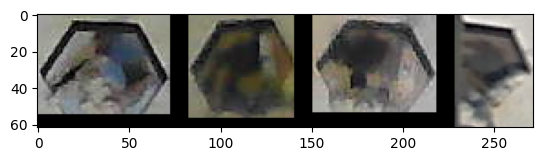

Waiting for movement
Starting Cycle    11 -- CapMac -- move idle
No changes, setting reference
Starting Cycle    12 -- CapMac -- move idle
CYCLE FAILURE!!!
Traceback (most recent call last):
  File "/tmp/ipykernel_42912/551630312.py", line 64, in cycle
    self.hc.capture()
  File "/home/musengdir/prj/dma/harmony/Observer.ipynb", line 648, in capture
    "            print(format_exc())\n",
  File "/home/musengdir/prj/dma/harmony/Observer.ipynb", line 648, in <dictcomp>
    "            print(format_exc())\n",
  File "/home/musengdir/prj/dma/harmony/Observer.ipynb", line 331, in capture
    "        patched = self.swapBox(self.baseFrame, self.referenceFrame, change.clipBox)\n",
  File "/home/musengdir/prj/dma/harmony/Observer.ipynb", line 377, in collectImage
    "            self.changes.remove(classifiedChange.lastChange)\n",
  File "/home/musengdir/.local/lib/python3.9/site-packages/requests/api.py", line 73, in get
    return request("get", url, params=params, **kwargs)
  File "/ho

KeyboardInterrupt: 

In [6]:
if __name__ == "__main__":
    for i in range(6):
        print("Waiting for movement")
        obj = cm.cycleForChange()
        plt.imshow(obj.visual())
        plt.show()